In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
import time
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN1 = 16
NUM_HIDDEN2 = 4
NUM_STATS = 1 + 2 * D
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 2000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'gibbs-mu'

In [3]:
Xs = torch.from_numpy(np.load('../gmm_fixed_sigma_dataset/obs.npy')).float()
STATES = torch.from_numpy(np.load('../gmm_fixed_sigma_dataset/states.npy')).float()
OBS_SIGMA = torch.from_numpy(np.load('../gmm_fixed_sigma_dataset/obs_sigma.npy')).float()
Pi = torch.from_numpy(np.load('../gmm_fixed_sigma_dataset/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_mu(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        
        self.mus_mu = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        self.mus_log_sigma = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        self.prior_mu = torch.zeros((K, D))
        self.prior_sigma = torch.ones((K, D)) * 3
        if CUDA:
            self.prior_mu = self.prior_mu.cuda()
            self.prior_sigma = self.prior_sigma.cuda()
        
    def forward(self, stat1, stat2, stat3):
        q = probtorch.Trace()
        stats_c1 = torch.cat((stat1[:, :, 0].unsqueeze(-1), stat2[:, :, 0, :], stat3[:, :, 0, :]), -1) ## S * B * 1+2*D
        stats_c2 = torch.cat((stat1[:, :, 1].unsqueeze(-1), stat2[:, :, 1, :], stat3[:, :, 1, :]), -1) ## S * B * 1+2*D
        stats_c3 = torch.cat((stat1[:, :, 2].unsqueeze(-1), stat2[:, :, 2, :], stat3[:, :, 2, :]), -1) ## S * B * 1+2*D
        ##
        q_mu1 = self.mus_mu(stats_c1)
        q_sigma1 = self.mus_log_sigma(stats_c1).exp()
        q_mu2 = self.mus_mu(stats_c2)
        q_sigma2 = self.mus_log_sigma(stats_c2).exp()
        q_mu3 = self.mus_mu(stats_c3)
        q_sigma3 = self.mus_log_sigma(stats_c3).exp()
        
        q_mu = torch.cat((q_mu1.unsqueeze(-2), q_mu2.unsqueeze(-2), q_mu3.unsqueeze(-2)), -2)
        q_sigma = torch.cat((q_sigma1.unsqueeze(-2), q_sigma2.unsqueeze(-2), q_sigma3.unsqueeze(-2)), -2)

        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')

        p = probtorch.Trace()
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        return q, p
        
def initialize():
    emc_mu = Enc_mu()
    if CUDA:
        emc_mu.cuda()
    optimizer =  torch.optim.Adam(list(emc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return emc_mu, optimizer

In [5]:
def loglikelihood_s(x, z, mu, sigma, D):
    # log-likelihoods
    """
    X should be expanded and repeated along the sample dim
    """
    labels = z.argmax(-1)
    labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
    x_mu = torch.gather(mu, 2, labels_flat)
#     x_sigma = torch.gather(sigma, 2, labels_flat)
    x_sigma = sigma
    return Normal(x_mu, x_sigma).log_prob(x).sum(-1).sum(-1) # S * B

In [6]:
enc_mu, optimizer = initialize()

In [ ]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_ex = []
KLs_in = []
flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO, ELBO, ESS, KLs_ex, KLs_in\n')
flog.close()
obs_sigma = OBS_SIGMA[0].cuda()
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_ex = 0.0
    KL_in = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        states = STATES[batch_indices]
        data = shuffler(torch.cat((obs, states), -1)).repeat(NUM_SAMPLES, 1, 1, 1)
        if CUDA:
            obs =data.cuda()[:, :, :, :2]
            states = data.cuda()[:, :, :, 2:]
        stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
        q, p = enc_mu(stat1, stat2, stat3)
        log_p_eta = p.log_joint(sample_dims=SAMPLE_DIM, batch_dim=BATCH_DIM)
        log_q_eta = q.log_joint(sample_dims=SAMPLE_DIM, batch_dim=BATCH_DIM)
        obs_mu = q['means'].value.view(NUM_SAMPLES, BATCH_SIZE, K, D)
        ll = loglikelihood_s(obs, states, obs_mu, obs_sigma[0], D)
        log_weights = ll + log_p_eta - log_q_eta
        weights = F.softmax(log_weights, 0).detach()
        eubo = (weights * log_weights).sum(0).mean()
        elbo = log_weights.mean()
        ess = (1. / (weights**2).sum(0)).mean()
        post_mu, post_sigma = Post_mu(stat1, stat2, enc_mu.prior_mu, enc_mu.prior_sigma, obs_sigma, D)
        q_mu = q['means'].dist.loc
        q_sigma = q['means'].dist.scale
        kl_ex, kl_in = kls_normals(q_mu, q_sigma, post_mu, post_sigma)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_ex += kl_ex.sum(-1).mean().item()
        KL_in += kl_in.sum(-1).mean().item()

    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    KLs_ex.append(KL_ex / NUM_BATCHES)
    KLs_in.append(KL_in / NUM_BATCHES)
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, KL_ex/NUM_BATCHES, KL_in/NUM_BATCHES), file=flog)
    flog.close()
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, KL_ex=%.3f, KL_in=%.3f (%ds)'
                % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, KL_ex/NUM_BATCHES, KL_in/NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-270.289, ELBO=-384.959, ESS=1.046, KL_ex=286.762, KL_in=37.817 (2s)
epoch=10, EUBO=-166.665, ELBO=-308.741, ESS=1.075, KL_ex=210.992, KL_in=14.145 (26s)
epoch=20, EUBO=-134.788, ELBO=-248.509, ESS=1.164, KL_ex=148.979, KL_in=10.672 (27s)
epoch=30, EUBO=-120.080, ELBO=-196.521, ESS=1.245, KL_ex=98.054, KL_in=9.978 (24s)
epoch=40, EUBO=-114.886, ELBO=-177.154, ESS=1.343, KL_ex=78.874, KL_in=8.836 (26s)
epoch=50, EUBO=-110.374, ELBO=-164.743, ESS=1.453, KL_ex=65.540, KL_in=7.032 (27s)
epoch=60, EUBO=-106.997, ELBO=-152.964, ESS=1.631, KL_ex=53.981, KL_in=5.673 (27s)
epoch=70, EUBO=-104.816, ELBO=-141.958, ESS=1.841, KL_ex=42.698, KL_in=4.702 (26s)
epoch=80, EUBO=-102.782, ELBO=-131.868, ESS=2.031, KL_ex=33.620, KL_in=4.042 (26s)
epoch=90, EUBO=-102.039, ELBO=-125.654, ESS=2.200, KL_ex=26.965, KL_in=3.576 (27s)
epoch=100, EUBO=-100.909, ELBO=-120.341, ESS=2.399, KL_ex=21.718, KL_in=3.157 (26s)
epoch=110, EUBO=-100.334, ELBO=-117.047, ESS=2.603, KL_ex=18.360, KL_in=2.816 (27s

In [15]:
torch.save(enc_mu.state_dict(), 'weights/enc-%s' + PATH)

In [9]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')

    ax1.tick_params(labelsize=18)
    
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-200, -90])
    ax1.legend()
    ax3.legend()
    ax3.tick_params(labelsize=18)
    plt.savefig('train_' + PATH + '.svg')

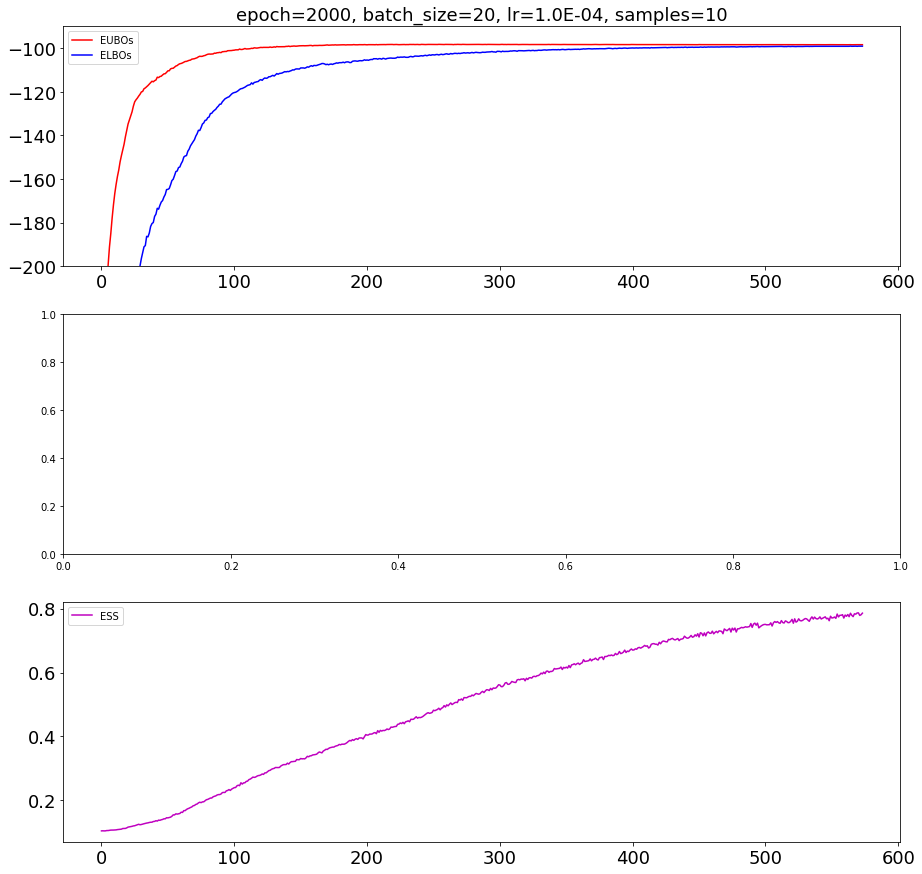

In [10]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [12]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    states = STATES[batch_indices]
    data = shuffler(torch.cat((obs, states), -1)).repeat(NUM_SAMPLES, 1, 1, 1)
    if CUDA:
        obs =data.cuda()[:, :, :, :2]
        states = data.cuda()[:, :, :, 2:]
    return obs, states

obs, states = sample_single_batch(NUM_SEQS, N, K, D, batch_size=25)
stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
q, p = enc_mu(stat1, stat2, stat3)

In [13]:
def plot_samples(obs, states, q, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,25))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    means_mean = q['means'].dist.loc[0].cpu().data.numpy()

    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
#         covs = np.zeros((K, D, D))
        mu = means_mean[b].reshape(K, D)
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(np.ones(2))
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
#             ax.scatter(x[:, 0], x[:, 1])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

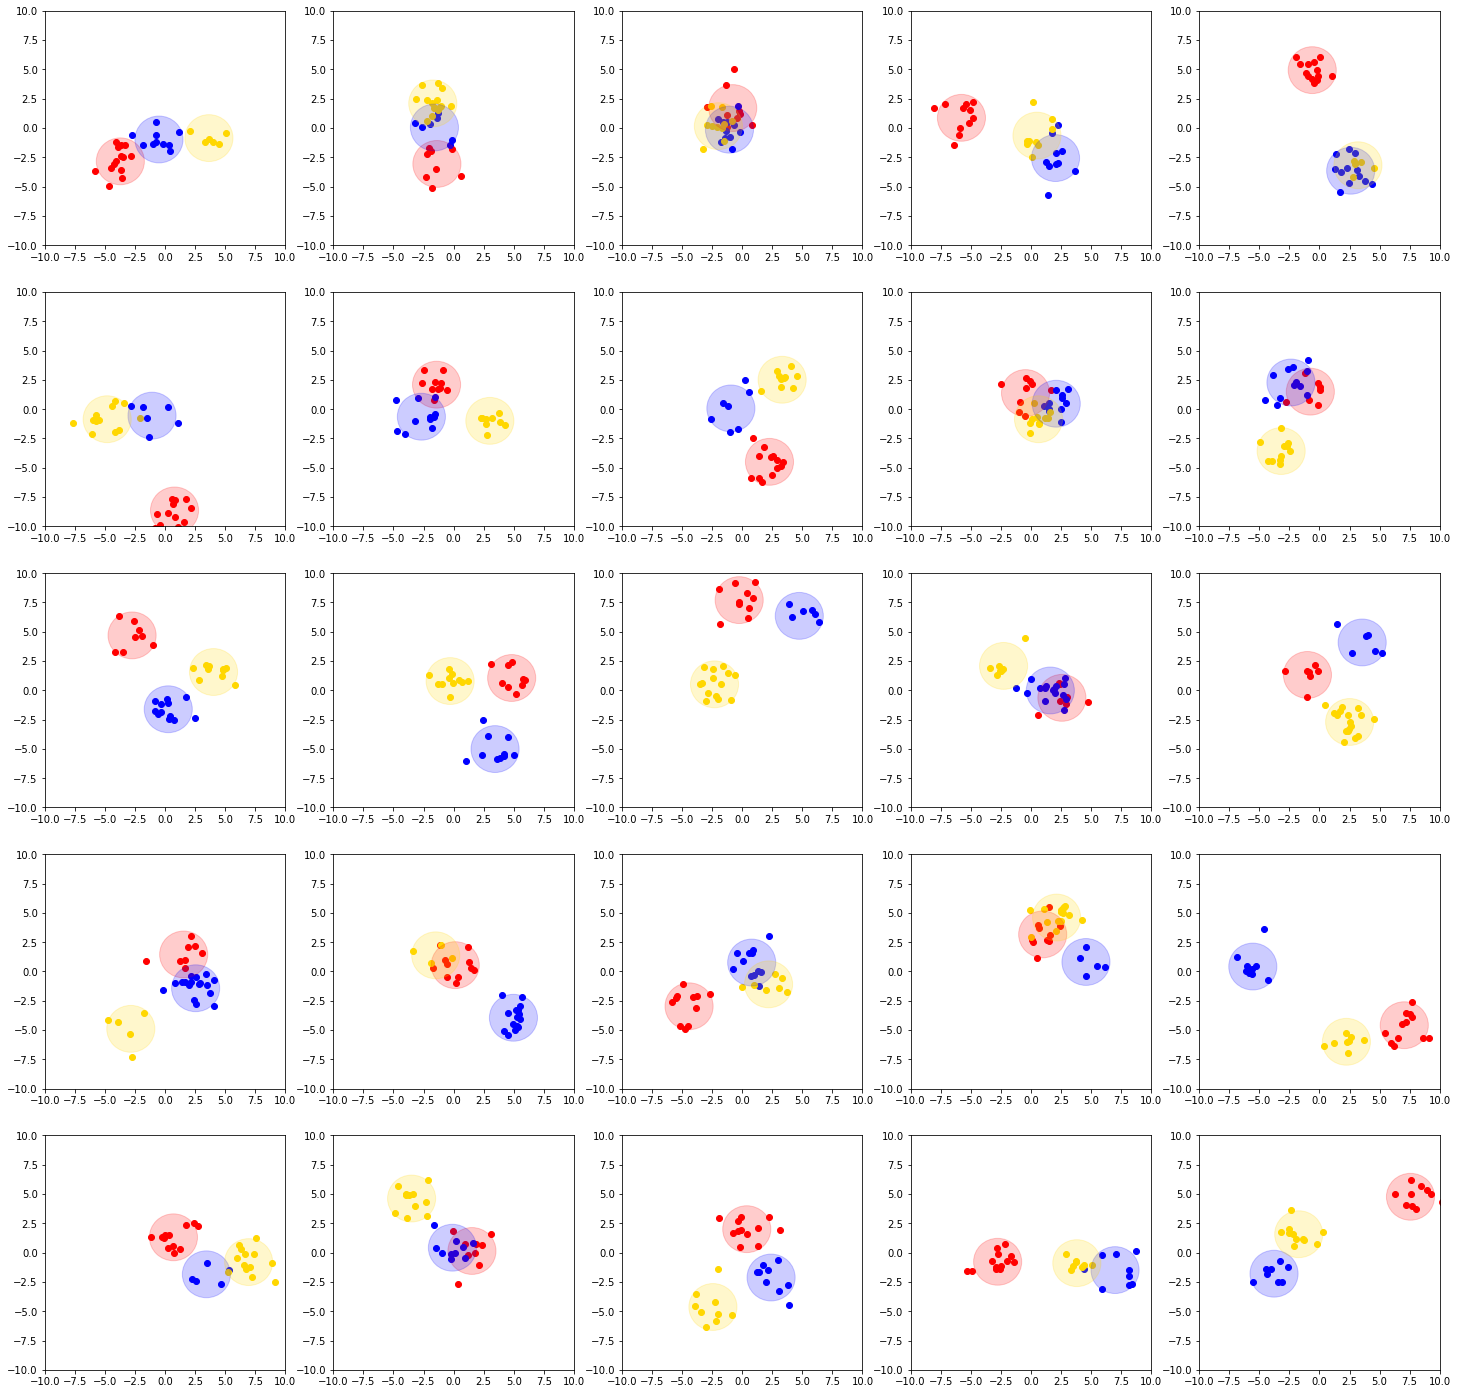

In [14]:
plot_samples(obs, states, q, batch_size=25)